In [1]:
import torch
import torchvision
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
trainset = datasets.CIFAR10('cifar',
            train=True, download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor()
            ]))

testset = datasets.CIFAR10('cifar', False,
                          transform = transforms.Compose([
                              transforms.Resize((32, 32)),
                              transforms.ToTensor()
                          ]))

trainset = DataLoader(trainset, batch_size=32, shuffle=True)
testset = DataLoader(testset, batch_size=32, shuffle=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 12835220.28it/s]


Extracting cifar/cifar-10-python.tar.gz to cifar


**Define the Resnet and the Classifier**

In [4]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [5]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Scaling Parameter
        # self.init_scaling_factor = torch.ones(num_classes)
        # self.scaling_factor = torch.nn.Parameter(self.init_scaling_factor, requires_grad=True)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

In [6]:
def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)

def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)


def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, Block, img_channels, num_classes)


def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101, Block, img_channels, num_classes)


def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152, Block, img_channels, num_classes)


def test():
    net = ResNet18(img_channels=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())

**Train the model**

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Detected device=>{device}, putting model to {device}")
model = ResNet50(img_channels=3, num_classes=10).to(device)
model

Detected device=>cuda, putting model to cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [8]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def compute_acc_bin(conf_thresh_lower, conf_thresh_upper, conf, pred, true):
    """
    # Computes accuracy and average confidence for bin

    Args:
        conf_thresh_lower (float): Lower Threshold of confidence interval
        conf_thresh_upper (float): Upper Threshold of confidence interval
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels

    Returns:
        (accuracy, avg_conf, len_bin): accuracy of bin, confidence of bin and number of elements in bin.
    """
    filtered_tuples = [x for x in zip(pred, true, conf) if x[2] > conf_thresh_lower and x[2] <= conf_thresh_upper]
    if len(filtered_tuples) < 1:
        return 0,0,0
    else:
        correct = len([x for x in filtered_tuples if x[0] == x[1]])  # How many correct labels
        len_bin = len(filtered_tuples)  # How many elements falls into given bin
        avg_conf = sum([x[2] for x in filtered_tuples]) / len_bin  # Avg confidence of BIN
        accuracy = float(correct)/len_bin  # accuracy of BIN
        return accuracy, avg_conf, len_bin


def ECE(conf, pred, true, bin_size = 0.1):
    """
    Expected Calibration Error

    Args:
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels
        bin_size: (float): size of one bin (0,1)  # TODO should convert to number of bins?

    Returns:
        ece: expected calibration error
    """

    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)  # Get bounds of bins

    n = len(conf)
    ece = 0  # Starting error

    for conf_thresh in upper_bounds:  # Go through bounds and find accuracies and confidences
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh-bin_size, conf_thresh, conf, pred, true)
        ece += np.abs(acc-avg_conf)*len_bin/n  # Add weigthed difference to ECE

    return ece


def get_bin_info(conf, pred, true, bin_size = 0.1):
    """
    Get accuracy, confidence and elements in bin information for all the bins.

    Args:
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels
        bin_size: (float): size of one bin (0,1)  # TODO should convert to number of bins?

    Returns:
        (acc, conf, len_bins): tuple containing all the necessary info for reliability diagrams.
    """

    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)

    accuracies = []
    confidences = []
    bin_lengths = []

    for conf_thresh in upper_bounds:
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh-bin_size, conf_thresh, conf, pred, true)
        accuracies.append(acc)
        confidences.append(avg_conf)
        bin_lengths.append(len_bin)


    return accuracies, confidences, bin_lengths

# reliability diagram plotting for subplot case.
def rel_diagram_sub(accs, confs, M = 10, name = "Reliability Diagram", xname = "Confidence", yname="Accuracy",save_name=""):
    acc_conf = np.column_stack([accs,confs])
    acc_conf.sort(axis=1)
    outputs = acc_conf[:, 0]
    gap = acc_conf[:, 1]

    bin_size = 1/M
    positions = np.arange(0+bin_size/2, 1+bin_size/2, bin_size)

    # Plot gap first, so its below everything
    gap_plt = plt.bar(positions, gap, width = bin_size, edgecolor = "red", color = "red", alpha = 0.3, label="Gap", linewidth=2, zorder=2)

    # Next add error lines
    #for i in range(M):
        #plt.plot([i/M,1], [0, (M-i)/M], color = "red", alpha=0.5, zorder=1)

    #Bars with outputs
    output_plt = plt.bar(positions, outputs, width = bin_size, edgecolor = "black", color = "blue", label="Outputs", zorder = 3)

    # Line plot with center line.
    plt.gca().set_aspect('equal')
    plt.plot([0,1], [0,1], linestyle = "--")
    plt.legend(handles = [gap_plt, output_plt])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title(f"{name}-{save_name}", fontsize=24)
    plt.xlabel(xname, fontsize=22, color = "black")
    plt.ylabel(yname, fontsize=22, color = "black")
    plt.savefig(f'/content/drive/MyDrive/Projects/Temperature Scaling of NN/{save_name}', dpi=300)

In [9]:
%%time
from tqdm import tqdm

num_epochs = 15
# track training metrics
loss_li,acc_li, epoch_error  = [], [], []
# track calibration metrics
conf, prediction, true = list(), list(), list()

for epoch in range(num_epochs):
    for idx, (x, label) in tqdm(enumerate(trainset),desc=f"Epoch {epoch+1}"):
        x, label = x.to(device), label.to(device)
        #print(x.shape, label.shape)
        logits = model(x) # b [b, 10]
        loss = criterion(logits, label) # label: [b]
        # backprop
        optimizer.zero_grad()
        loss.backward()
        # gradient descent
        optimizer.step()

    model.eval()
    with torch.no_grad():
        tot_corr = 0
        tot_num = 0
        epoch_calib_error = 0
        for x, label in testset:
            x, label = x.to(device), label.to(device)
            true.append(label.detach().cpu().numpy())
            logits = model(x)
            pred = logits.argmax(dim=1)
            conf.append(
                logits.softmax(dim=1).max(dim=1).values.detach().cpu().numpy()
                )
            prediction.append(pred.detach().cpu().numpy())
            # calculate the expected calibration error for the current batch
            batch_calib_error = ECE(conf=logits.softmax(dim=1).max(dim=1).values.detach().cpu().numpy(),
                                    pred=pred,true=label)
            epoch_calib_error = epoch_calib_error + batch_calib_error
            # using item() to convert tensor to number
            tot_corr += torch.eq(pred, label).float().sum().item()
            tot_num += x.size(0)
        acc = tot_corr / tot_num

    loss_li.append(loss.item())
    acc_li.append(acc)
    epoch_error.append(epoch_calib_error)
    print('epoch: {}, loss: {}, acc: {}, error: {}'.format(epoch+1, loss, acc, epoch_calib_error))
    # break

Epoch 1: 1563it [00:59, 26.08it/s]


epoch: 1, loss: 1.9495996236801147, acc: 0.2784, error: 40.26668085483834


Epoch 2: 1563it [00:53, 29.01it/s]


epoch: 2, loss: 1.6251808404922485, acc: 0.4218, error: 49.88692160649225


Epoch 3: 1563it [00:54, 28.69it/s]


epoch: 3, loss: 1.5338184833526611, acc: 0.4488, error: 55.14518718980253


Epoch 4: 1563it [00:55, 28.34it/s]


epoch: 4, loss: 1.4062449932098389, acc: 0.5305, error: 54.72974491631612


Epoch 5: 1563it [00:54, 28.59it/s]


epoch: 5, loss: 2.000093460083008, acc: 0.5162, error: 54.172761633992195


Epoch 6: 1563it [00:54, 28.60it/s]


epoch: 6, loss: 0.9268693327903748, acc: 0.5356, error: 52.343491384759545


Epoch 7: 1563it [00:53, 29.13it/s]


epoch: 7, loss: 0.7034850716590881, acc: 0.6097, error: 53.75467464886606


Epoch 8: 1563it [00:54, 28.89it/s]


epoch: 8, loss: 0.9296272993087769, acc: 0.6126, error: 50.23660175874829


Epoch 9: 1563it [00:53, 29.10it/s]


epoch: 9, loss: 1.0327692031860352, acc: 0.6375, error: 51.853504756931216


Epoch 10: 1563it [00:54, 28.47it/s]


epoch: 10, loss: 0.5596019625663757, acc: 0.6334, error: 52.918253098614514


Epoch 11: 1563it [00:54, 28.86it/s]


epoch: 11, loss: 0.5397365093231201, acc: 0.6558, error: 51.6976405242458


Epoch 12: 1563it [00:53, 28.98it/s]


epoch: 12, loss: 0.7251644134521484, acc: 0.6659, error: 54.07609369419515


Epoch 13: 1563it [00:54, 28.77it/s]


epoch: 13, loss: 0.39856648445129395, acc: 0.6675, error: 55.0257528340444


Epoch 14: 1563it [00:55, 28.33it/s]


epoch: 14, loss: 0.9166768789291382, acc: 0.6678, error: 55.37884868122637


Epoch 15: 1563it [00:54, 28.92it/s]


epoch: 15, loss: 0.7496604919433594, acc: 0.6708, error: 59.45909462729469
CPU times: user 14min 40s, sys: 6.02 s, total: 14min 46s
Wall time: 15min 1s


In [10]:
conf = [j for i in conf for j in i]
prediction = [j for i in prediction for j in i]
true = [j for i in true for j in i]
_acc, _confs, _ = get_bin_info(conf,prediction,true)

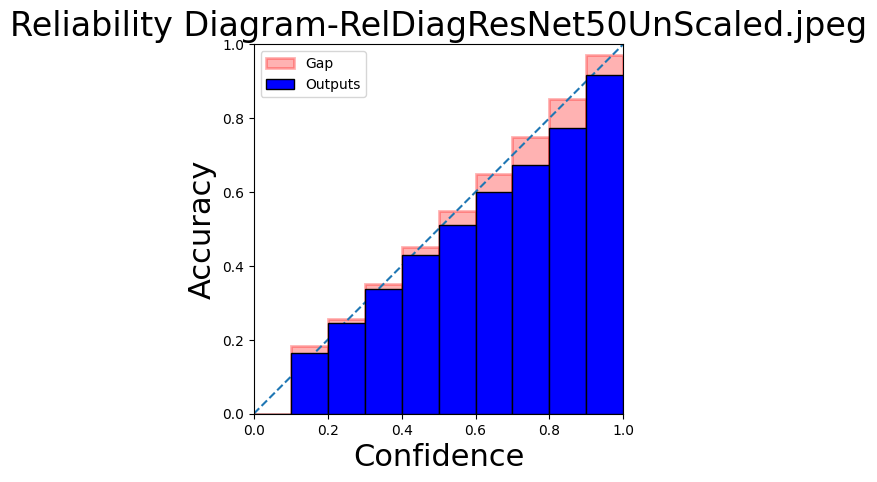

In [11]:
rel_diagram_sub(_acc,_confs,save_name="RelDiagResNet50UnScaled.jpeg")

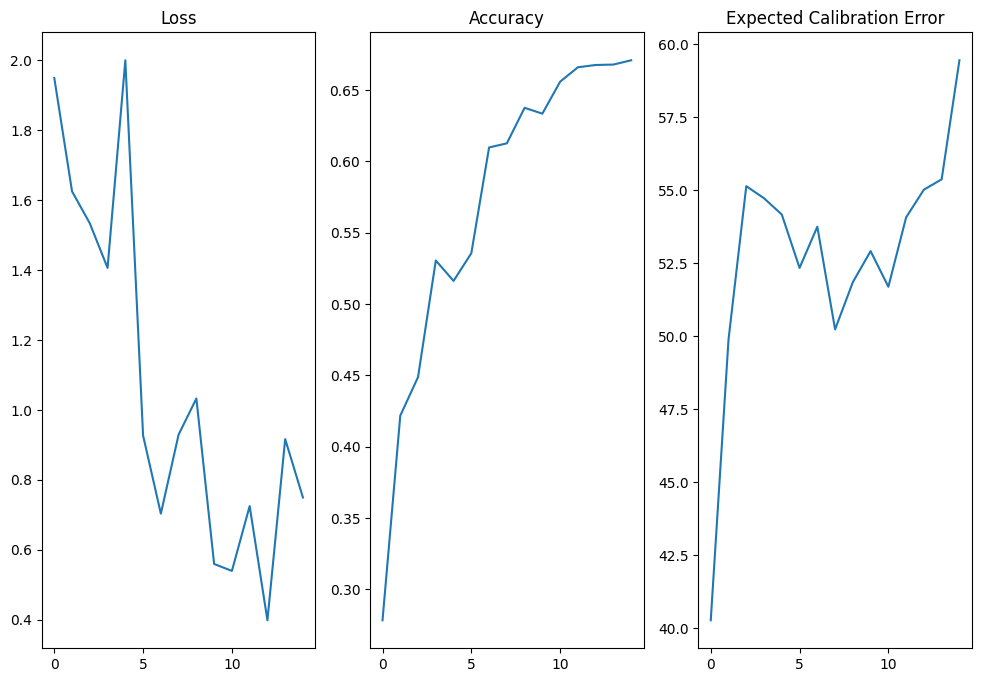

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].plot(loss_li)
ax[0].set_title('Loss')
ax[1].plot(acc_li)
ax[1].set_title('Accuracy')
ax[2].plot(epoch_error)
ax[2].set_title('Expected Calibration Error')
plt.savefig('/content/drive/MyDrive/Projects/Temperature Scaling of NN/ResNet50UnScaledTrainingMetrics.jpeg', dpi=300)

In [13]:
import pandas as pd

metrics_df = pd.DataFrame({
    'Loss':loss_li,
    'Accuracy':acc_li,
    'ECE':epoch_error
}).reset_index(drop=False).rename(columns={'index':'Epoch'})
metrics_df

,Epoch,Loss,Accuracy,ECE
0,0,1.949600,0.2784,40.266681
1,1,1.625181,0.4218,49.886922
2,2,1.533818,0.4488,55.145187
3,3,1.406245,0.5305,54.729745
4,4,2.000093,0.5162,54.172762
5,5,0.926869,0.5356,52.343491
6,6,0.703485,0.6097,53.754675
7,7,0.929627,0.6126,50.236602
8,8,1.032769,0.6375,51.853505
9,9,0.559602,0.6334,52.918253


In [14]:
save_path = '/content/drive/MyDrive/Projects/Temperature Scaling of NN/ResNet50UnScaled.pth'

metrics_df.to_csv('/content/drive/MyDrive/Projects/Temperature Scaling of NN/ResNet50UnScaledMetrics.csv',index=False)
checkpoint = {'model': ResNet50(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, save_path)

### Checking the optimal temperature for an unscaled model

In [15]:
from tqdm import tqdm

def eval_step(temp_value:float):
    model.eval()
    epoch_calib_error = 0
    with torch.no_grad():
        for x, label in testset:
            x, label = x.to(device), label.to(device)
            logits = model(x)
            logits = logits/temp_value
            pred = logits.argmax(dim=1)
            batch_calib_error = ECE(conf=logits.softmax(dim=1).max(dim=1).values.detach().cpu().numpy(),
                                    pred=pred,true=label)
            epoch_calib_error = epoch_calib_error + batch_calib_error

    return epoch_calib_error

"""
    we try to scale the logits with random temperature
    values ranging from 0 to 1 with a step size of .10 as a grid
    search method to see if the values provided during training
    are the most optimal ones or not.
"""

response = []
temp_values = np.arange(1,2,0.1)

for temp in tqdm(temp_values,desc='Temp Values'):
    error_val = eval_step(temp)
    response.append({
        'Temp Value':temp,
        'ECE':error_val
    })
    # break

Temp Values: 100%|██████████| 10/10 [00:54<00:00,  5.46s/it]


In [16]:
response = pd.DataFrame(response)
print("Min ECE value=>",response['ECE'].min())
print("Optimal temperature values=>\n",response[response['ECE']==response['ECE'].min()]['Temp Value'].unique())

Min ECE value=> 49.47444021189585
Optimal temperature values=>
 [1.9]


In [17]:
response

,Temp Value,ECE
0,1.0,58.520666
1,1.1,55.650432
2,1.2,53.368889
3,1.3,52.534268
4,1.4,50.957153
5,1.5,50.336603
6,1.6,49.579397
7,1.7,50.893114
8,1.8,50.220447
9,1.9,49.474440


In [18]:
# track calibration metrics
conf_post, prediction_post, true_post = list(), list(), list()

model.eval()
with torch.no_grad():
    for x, label in testset:
        x, label = x.to(device), label.to(device)
        true_post.append(label.detach().cpu().numpy())
        logits = model(x)
        # scale the logits by the optimal temperature value
        logits = logits/1.9
        pred = logits.argmax(dim=1)
        conf_post.append(
            logits.softmax(dim=1).max(dim=1).values.detach().cpu().numpy()
            )
        prediction_post.append(pred.detach().cpu().numpy())


conf_post = [j for i in conf_post for j in i]
prediction_post = [j for i in prediction_post for j in i]
true_post = [j for i in true_post for j in i]
_acc_post, _confs_post, _ = get_bin_info(conf_post,prediction_post,true_post)

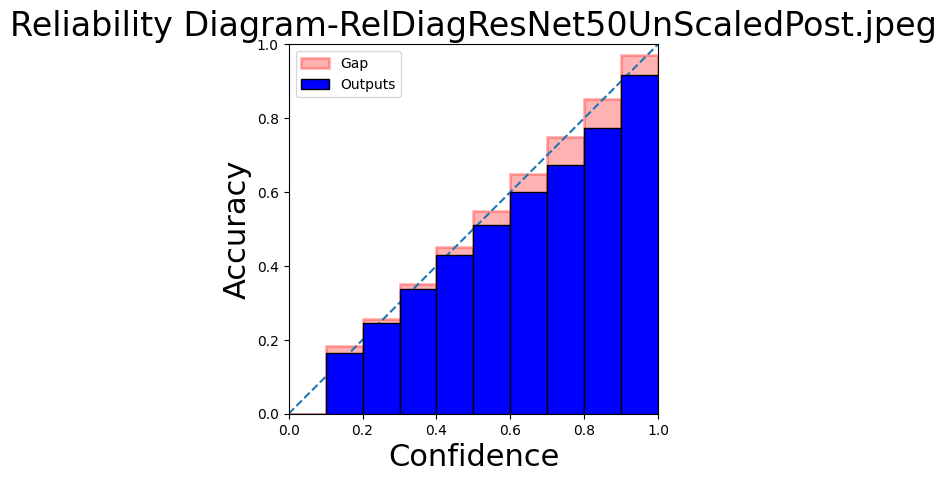

In [19]:
# now we take the temp value for the min ECE and generate it's Reliability Diagram
rel_diagram_sub(_acc,_confs,save_name="RelDiagResNet50UnScaledPost.jpeg")